In [1]:
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

In [2]:
FAKE_PATH = 'dataset/neptune.csv' 
NORMAL_PAYH = 'dataset/normal.csv'
FEATURES = [
    'duration',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'count',
    'serror_rate',
    'rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_count',
    'srv_serror_rate',
    'srv_rerror_rate',
    'srv_diff_host_rate'
]

In [3]:
# load fake and normal observation
fo_df = pd.read_csv(FAKE_PATH)[FEATURES]
no_df = pd.read_csv(NORMAL_PAYH)[FEATURES]

In [4]:
fo_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,count,serror_rate,rerror_rate,same_srv_rate,diff_srv_rate,srv_count,srv_serror_rate,srv_rerror_rate,srv_diff_host_rate
0,0,0,0,0,0,0,157,1.0,0.0,0.04,0.09,6,1.0,0.0,0.0
1,0,0,0,0,0,0,109,1.0,0.0,0.07,0.07,8,1.0,0.0,0.0
2,0,0,0,0,0,0,13,1.0,0.0,0.62,0.15,8,1.0,0.0,0.0
3,0,0,0,0,0,0,260,0.0,1.0,0.05,0.06,12,0.0,1.0,0.0
4,0,0,0,0,0,0,197,1.0,0.0,0.02,0.07,4,1.0,0.0,0.0


In [5]:
no_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,count,serror_rate,rerror_rate,same_srv_rate,diff_srv_rate,srv_count,srv_serror_rate,srv_rerror_rate,srv_diff_host_rate
0,0,45,78,0,0,0,161,0.0,0.0,1.0,0.0,161,0.0,0.0,0.00
1,2474,147,105,0,0,0,1,0.0,0.0,1.0,0.0,1,0.0,0.0,0.00
2,0,329,306,0,0,0,2,0.0,0.0,1.0,0.0,22,0.0,0.0,0.14
3,0,42,42,0,0,0,3,0.0,0.0,1.0,0.0,9,0.0,0.0,0.22
4,25,1716,367,0,0,0,1,0.0,0.0,1.0,0.0,1,0.0,0.0,0.00


In [6]:
fo_no = shuffle(np.vstack([fo_df.values, no_df.values]))

In [7]:
ss = StandardScaler().fit(fo_no)

In [9]:
fo_no = ss.transform(fo_no)
pca = PCA(n_components=2).fit(fo_no)

In [12]:
fo_no = pca.transform(fo_no)

In [14]:
ss_ = StandardScaler().fit(fo_no)

In [15]:
fo_no[:3]

array([[-1.90359275, -0.42250245],
       [ 1.65716955, -0.65902321],
       [ 1.6550512 , -0.65715112]])

In [16]:
fo_no = ss_.transform(fo_no)

In [17]:
fo_no[:3]

array([[-1.01856168, -0.28184218],
       [ 0.8867072 , -0.43962002],
       [ 0.88557373, -0.43837119]])

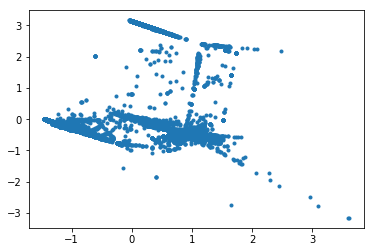

In [19]:
plt.plot(fo_no[:,0], fo_no[:,1], '.')
plt.show()

In [21]:
fake_observations = ss_.transform(pca.transform(ss.transform(fo_df.values)))
normal_observations = ss_.transform(pca.transform(ss.transform(no_df.values)))

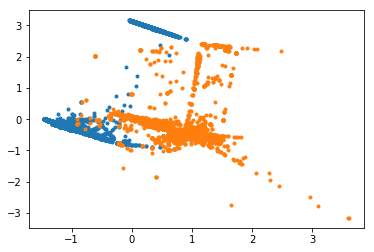

In [22]:
plt.plot(fake_observations[:,0], fake_observations[:,1], '.')
plt.plot(normal_observations[:,0], normal_observations[:,1], '.')
plt.show()

In [20]:
from sklearn.cluster import MiniBatchKMeans

## fake: 200

In [52]:
cls = MiniBatchKMeans(n_clusters=120, max_iter=3000, batch_size=512, verbose=False, n_init=10)
cls.fit(fake_observations)
labels = np.unique(cls.labels_)
predicted = cls.predict(fake_observations)
indeices = np.arange(predicted.shape[0])
fake_index_labels = []
for i in labels:
    fake_index_labels.append(indeices[predicted == i])

In [53]:
pd.Series([len(fil)for fil in fake_index_labels]).describe()

count    120.000000
mean     333.333333
std      266.290589
min        7.000000
25%      115.000000
50%      280.500000
75%      471.000000
max      935.000000
dtype: float64

## normal: 50

In [54]:
cls = MiniBatchKMeans(n_clusters=40, max_iter=3000, batch_size=512, verbose=False, n_init=10)
cls.fit(normal_observations)
labels = np.unique(cls.labels_)
predicted = cls.predict(normal_observations)
indeices = np.arange(predicted.shape[0])
normal_index_labels = []
for i in labels:
    normal_index_labels.append(indeices[predicted == i])

In [55]:
pd.Series([len(nil)for nil in normal_index_labels]).describe()

count      40.000000
mean     1000.000000
std      1290.850465
min        53.000000
25%       312.750000
50%       582.500000
75%      1163.250000
max      7369.000000
dtype: float64

## select 40 + 120

In [60]:
best_ind, best_score = None, None
for epioch in range(10000):
    fils = [fake_observations[np.random.choice(fil)] for fil in fake_index_labels]
    nils = [normal_observations[np.random.choice(nil)] for nil in normal_index_labels]
    fils_nils = np.array(fils+nils)
    d_min = None
    for i in range(fils_nils.shape[0]):
        for j in range(i+1, fils_nils.shape[0]):
            x1 = fils_nils[i]
            x2 = fils_nils[j]
            d = np.linalg.norm(x1 - x2)
            if d_min is None or d < d_min:
                d_min = d
    if best_score is None or (d > best_score):
        best_ind = [np.array(fils), np.array(nils)]
        best_score = d
    print('\rMinimum distance {}/{}'.format(d, best_score), end='')

Minimum distance 0.07211157249534866/0.144453297022496155

(120, 2)
(40, 2)


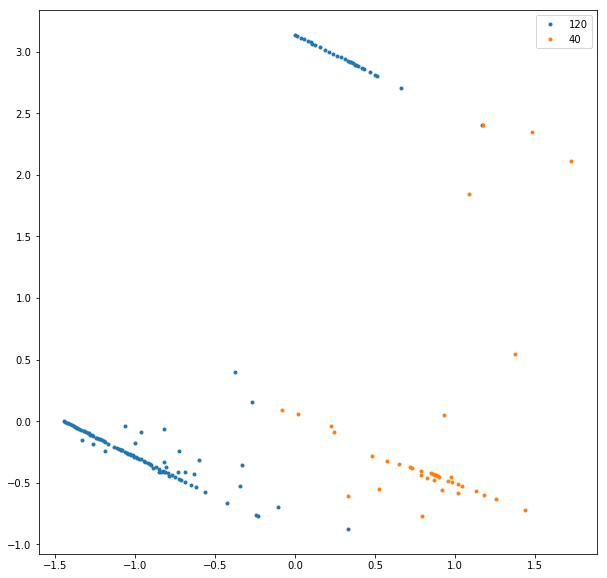

In [61]:
plt.figure(figsize=(10,10))
for xy in best_ind:
    print(xy.shape)
    plt.plot(xy[:,0], xy[:,1], '.', label=str(xy.shape[0]))
plt.legend()
plt.show()

In [69]:
fake_df = pd.DataFrame(best_ind[0])
fake_df.rename(columns={0:'component_0', 1:'component_1'}, inplace=True)
# fake_df.to_csv('dataset/fake_observation.csv', index=False)
fake_df

,component_0,component_1
0,-1.296348,-0.098650
1,0.308626,2.937227
2,-0.812381,-0.413934
3,-1.005885,-0.290126
4,-0.245787,-0.763040
5,0.078676,3.089008
6,-1.384672,-0.041460
7,-1.220717,-0.147757
8,0.499296,2.811361
9,-0.620270,-0.533805


In [70]:
normal_df = pd.DataFrame(best_ind[1])
normal_df.rename(columns={0:'component_0', 1:'component_1'}, inplace=True)
# normal_df.to_csv('dataset/normal_observation.csv', index=False)
normal_df

,component_0,component_1
0,0.877883,-0.435616
1,1.482642,2.348651
2,0.016323,0.057908
3,1.438108,-0.724432
4,0.478724,-0.285642
5,1.016291,-0.507416
6,1.173246,2.400497
7,0.874239,-0.435295
8,1.725320,2.114941
9,0.787466,-0.401347


In [ ]:
np.random.permutation()